# Layer Normalization

本教程主要是使用 Triton 实现了一个高性能的 Layer Normalization Kernel，该 Kernel 的性能超过了 Pytorch 的 `F.layer_norm` 算子。本教程分别实现了 Layer Normalization 的 Forward 和 Backward 过程，无论是前向还是反向计算过程，都融合为了一个 Kernel 来实现，正如在 [Fused Softmax](./fused-softmax.ipynb) 介绍的一样，这样融合后的算子可以大幅减少访存的量，提升计算密度。

**层归一化（LayerNorm）** 运算符最早在[BA2016](https://arxiv.org/abs/1607.06450)中被引入，作为一种提高序列模型（例如 Transformer）或小批量神经网络性能的方法。在非 Batch 化的形式下，它以向量 $\mathbf{x}$ 作为输入，并生成与输出具有相同形状的向量 $\mathbf{y}$。归一化通过减去 $\mathbf{x}$ 的均值并除以其标准差来执行。在归一化之后，额外进行一个具有权重 $\mathbf{w}$ 和偏置 $\mathbf{b}$ 的可学习线性变换。

$$\mathbf{y} = \frac{ \mathbf{x} - \text{E}[\mathbf{x}] }{ \sqrt{\text{Var}(\mathbf{x}) + \epsilon} } * \mathbf{w} + \mathbf{b}$$

Layer Normalization 的正向与反向的计算公式推导如下：

| Forward | Backward | Comment |
| --- | --- | --- |
| $m = \frac{1}{N}\sum \mathbf{x},\mathbf{x} \in \mathbb{R}^N, m\in \mathbb{R}$ | $\frac{\partial m}{\partial \mathbf{x}_i} = \frac{1}{N}$ ||
| $\sigma=\sqrt{\frac{1}{N}\sum(\mathbf{x}-m)^2+\epsilon},\omega=\frac{1}{\sigma}$ | $\frac{\partial \omega}{\partial \mathbf{x}} = -\frac{1}{2}\frac{1}{\sigma^3}\frac{2}{N}(\mathbf{x}-m) + \frac{\partial \omega}{\partial m}\cdot \frac{\partial m}{\partial \mathbf{x}}  \\ = -\frac{1}{2}\frac{1}{\sigma^3}\frac{2}{N} \left(\mathbf{x} -m  + \sum(m-\mathbf{x})\frac{1}{N}\right)  \\ = -\frac{1}{N}\frac{1}{\sigma^3}\left(\mathbf{x} -m\right) \\ = -\frac{1}{N}\frac{1}{\sigma^2} \hat{\mathbf{x}}$ |该步利用了 $\sum(m-\mathbf{x})\frac{1}{N} = 0$|
|$\hat{\mathbf{x}} = \frac{\mathbf{x} - m}{\sigma} = (\mathbf{x} - m)\omega$| $\frac{\partial \hat{\mathbf{x}}_i}{\partial \mathbf{x}_j} = \omega \delta_{i,j} - \omega \frac{\partial m}{\partial \mathbf{x}_j} + (\mathbf{x}_i -m)\frac{\partial \omega}{\partial \mathbf{x}_j} \\ = \frac{1}{\sigma}\left(\delta_{i,j} - \frac{1}{N}\right) - (\mathbf{x}_i -m) \frac{1}{N} \frac{1}{\sigma^2} \hat{\mathbf{x}}_j \\ = \frac{1}{\sigma}\left(\delta_{i,j} - \frac{1}{N}\right) - \hat{\mathbf{x}}_i\frac{1}{N}\frac{1}{\sigma}\hat{\mathbf{x}_j}$ | $\delta_{i,j}$代表只有当$i=j$时取值为 1，否则为 0|
||$\nabla_\mathbf{x}=J\cdot \nabla_\mathbf{\hat{x}}, J_{i,j} = \frac{\partial \hat{\mathbf{x}}_i}{\partial \mathbf{x}_j}$ | $J$表示向量 $\mathbf{y}$ 对向量 $\hat{\mathbf{x}}$ 求导时的 Jacobian 矩阵 |
||$\nabla_{\mathbf{x}_j} = \sum_i J_{j,i}\nabla_{\hat{\mathbf{x}}_i}=\sum_i\frac{\partial \hat{\mathbf{x}}_i}{\partial \mathbf{x}_j} \nabla_{\hat{\mathbf{x}}_i}  \\ = \sum_i \nabla_{\hat{\mathbf{x}}_i} \frac{1}{\sigma}(\delta_{i,j} - \frac{1}{N}) - \sum_i \nabla_{\hat{\mathbf{x}}_i} \hat{\mathbf{x}}_i\frac{1}{N}\frac{1}{\sigma}\hat{\mathbf{x}_j}$ | $\nabla_{\mathbf{x}_j}$ 等于 $J$ 的第 $j$ 行与 $\nabla_{\hat{\mathbf{x}}}$ 求 dot-product|
|$\mathbf{y} = \mathbf{w} \hat{\mathbf{x}} + \mathbf{b}$|$\nabla\mathbf{x}_j = \sum_i\frac{\partial \hat{\mathbf{x}}_i}{\partial \mathbf{x}_j} \nabla\hat{\mathbf{x}}_i = \sum_i \nabla \mathbf{\hat{x}}_i \frac{1}{\sigma}(\delta_{i,j} - \frac{1}{N}) - \sum_i \nabla \hat{\mathbf{x}}_i \hat{\mathbf{x}}_i\frac{1}{N}\frac{1}{\sigma}\hat{\mathbf{x}_j}  \\ = \sum_i \nabla \mathbf{y}_i\mathbf{w}_i\frac{1}{\sigma}(\delta_{i,j} - \frac{1}{N}) - \sum_i  \nabla \mathbf{y}_i\mathbf{w}_i\hat{\mathbf{x}}_i\frac{1}{N}\frac{1}{\sigma}\hat{\mathbf{x}_j} \\ = \frac{1}{\sigma} \left( \nabla \mathbf{y}_j\mathbf{w}_j - \frac{1}{N}\sum_i \nabla \mathbf{y}_i\mathbf{w}_i - \frac{1}{N} \hat{\mathbf{x}_j} \sum_i  \nabla \mathbf{y}_i\mathbf{w}_i\hat{\mathbf{x}}_i\right) \\ = \frac{1}{\sigma} \left( [\nabla \mathbf{y} \odot \mathbf{w}]_j - \frac{1}{N}\nabla \mathbf{y}\cdot \mathbf{w} - \frac{1}{N} \hat{\mathbf{x}_j} \nabla (\mathbf{y} \odot \mathbf{w})\cdot \hat{\mathbf{x}}\right)$|$\sum_i  \nabla \mathbf{y}_i\mathbf{w}_i$ 本质上就是向量 $\mathbf{y}$ 与和向量 $\mathbf{w}$ 求 dot_product|
||$\nabla_{\mathbf{x}} = \frac{1}{\sigma} \left( \nabla_{\mathbf{y}} \odot \mathbf{w} - \underbrace{\frac{1}{N}\nabla_{\mathbf{y}}\cdot \mathbf{w}}_{c_2} - \hat{\mathbf{x}} \odot \underbrace{\frac{1}{N} \left((\nabla_{\mathbf{y}} \odot \mathbf{w})\cdot \hat{\mathbf{x}}\right)}_{c_1}\right)$|
||$\nabla_{\mathbf{w}} = \nabla_{\mathbf{y}} \odot \hat{\mathbf{x}} \\ \nabla_{\mathbf{b}} = \nabla_{\mathbf{y}}$|

## LayerNorm 前向实现

LayerNorm 的前向实现的 Kernel，每个线程块计算矩阵的一行，在序列模型中往往对应了一个样本。为了避免某些形状输入最后一维太大，Kernel 中在计算均值、方差以及最后进行归一化时，都是按 BLOCK 进行循环处理的。
 
以下代码实现中，需要额外关注的是 Kernel 内部在计算均值与方差时都是按 `float32` 精度来计算的，这对于 Normalization 这类的算子是很重要的。在最后计算 `y` 时，得到的 `y` 也是 `float32`类型，但 `tl.store` 在存储时可以正确的处理类型转换的问题。

对于 `BLOCK_SIZE` 的设置问题，理论上来说越大越好，但太大的 `BLOCK_SIZE` 会导致 Kernel 需要较大的 SharedMemory 和寄存器数量，进一步影响 Occupancy。

In [1]:
import torch
import torch.nn.functional as F
import triton
import triton.language as tl


@triton.jit
def layer_norm_fwd_kernel(
    X,  # X: input of shape [batch_size, N]
    Y,  # Y: output of shape [batch_size, N]
    W,  # W: weight of shape [N]
    B,  # B: bias of shape [N]
    Mean,  # Mean: mean of each row in X, shape [batch_size]
    Rstd,  # Rstd: 1/sqrt(variance + eps) of each row in X, shape [batch_size]
    stride,  # stride: leading dimension of X and Y
    N,  # N: size of last dimension
    eps,  # eps: epsilon value for numerical stability
    # BLOCK_SIZE: number of elements computed by each program instance
    BLOCK_SIZE: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    row = pid

    # 将 X 和 Y 都定位到指定当前线程块对应的那一行数据上
    X += row * stride
    Y += row * stride

    # 计算 X 中第 row 行数组的均值
    # 依次计算出每个 BLOCK_SIZE 区间内的 mean，然后相加在一起
    block_mean = tl.zeros((BLOCK_SIZE,), dtype=tl.float32)
    for blk_start in range(0, N, BLOCK_SIZE):
        offsets = blk_start + tl.arange(0, BLOCK_SIZE)
        x = tl.load(X + offsets, mask=offsets < N, other=0).to(tl.float32)
        block_mean += x
    mean = tl.sum(block_mean) / N
    tl.store(Mean + row, mean)

    # 计算 X 中第 row 行数组的方差
    block_var = tl.zeros((BLOCK_SIZE,), dtype=tl.float32)
    for blk_start in range(0, N, BLOCK_SIZE):
        offsets = blk_start + tl.arange(0, BLOCK_SIZE)
        x = tl.load(X + offsets, mask=offsets < N, other=0).to(tl.float32)
        # 下面这段代码需要额外注意，超过边界上的 x 中的元素减去均值后，就不再为 0 了，所以要额外过滤
        x = tl.where(offsets < N, x - mean, 0.0)
        block_var += x * x
    var = tl.sum(block_var) / N
    rstd = 1 / tl.sqrt(var + eps)
    tl.store(Rstd + row, rstd)

    # 对 x 应用规一化
    for blk_start in range(0, N, BLOCK_SIZE):
        offsets = blk_start + tl.arange(0, BLOCK_SIZE)
        mask = offsets < N
        x = tl.load(X + offsets, mask=mask).to(tl.float32)
        w = tl.load(W + offsets, mask=mask)
        b = tl.load(B + offsets, mask=mask)
        y = (x - mean) * rstd * w + b
        tl.store(Y + offsets, y, mask=mask)


def layer_norm_fwd(x: torch.Tensor, weight: torch.Tensor, bias: torch.Tensor, eps=1e-5):
    assert x.is_cuda and weight.is_cuda and bias.is_cuda

    output = torch.zeros_like(x)

    feature_dim = x.size(-1)
    x = x.view(-1, feature_dim)
    n = x.size(0)
    mean = torch.zeros(n, dtype=x.dtype, device="cuda")
    rstd = torch.zeros(n, dtype=x.dtype, device="cuda")
    grid = (n,)
    layer_norm_fwd_kernel[grid](
        x,
        output,
        weight,
        bias,
        mean,
        rstd,
        stride=x.stride(0),
        N=feature_dim,
        eps=eps,
        BLOCK_SIZE=64,
    )
    return output


batch_size = 2
seq_len = 3
feature_dim = 160
x = torch.randn(batch_size, seq_len, feature_dim, device="cuda", dtype=torch.float16)
weight = torch.randn((feature_dim,), device="cuda", dtype=torch.float16)
bias = torch.zeros((feature_dim,), device="cuda", dtype=torch.float16)

layer_norm_output_torch = F.layer_norm(x, (feature_dim,), weight=weight, bias=bias)
layer_norm_output_triton = layer_norm_fwd(x, weight, bias)

print(torch.allclose(layer_norm_output_torch, layer_norm_output_triton, atol=1e-6))

True


## LayerNorm 的反向实现

反向传播函数要求根据 $\mathbf{y}$的梯度 $\nabla_{\mathbf{y}}$ 来计算 $\mathbf{x}$、$\mathbf{w}$、$\mathbf{b}$的梯度。

$$
\nabla_{\mathbf{x}} = \frac{1}{\sigma} \left( \nabla_{\mathbf{y}} \odot \mathbf{w} - \underbrace{\frac{1}{N}\nabla_{\mathbf{y}}\cdot \mathbf{w}}_{c_2} - \hat{\mathbf{x}} \odot \underbrace{\frac{1}{N} \left((\nabla_{\mathbf{y}} \odot \mathbf{w})\cdot \hat{\mathbf{x}}\right)}_{c_1}\right) \\
\nabla_{\mathbf{w}} = \nabla_{\mathbf{y}} \odot \hat{\mathbf{x}} \\
\nabla_{\mathbf{b}} = \nabla_{\mathbf{y}}
$$

从上面的公式中，可以看出，要计算 $\nabla_{\mathbf{x}}$，我们除了 $\nabla_{\mathbf{y}}$ 外，还需要计算 $\hat{\mathbf{x}}$，我们可以将 Forward 过程中计算得到的每一行的均值与标准差的倒数保存起来，用于在 Backward 时快速重新计算 $\hat{\mathbf{x}}$。

由于在同一批次中的所有行都使用相同的权重 $\mathbf{w}$ 和偏置 $\mathbf{b}$，它们的梯度需要累加。为了有效地执行这一步，我们使用并行归约策略：每个内核实例将特定行的部分 $\nabla_{\mathbf{w}}$ 和 $\nabla_{\mathbf{b}}$ 累加到 `GROUP_SIZE_M` 个独立缓冲区中的一个。这些缓冲区驻留在 L2 缓存中，然后由另一个函数进一步归约以计算实际的 $\nabla_{\mathbf{w}}$ 和 $\nabla_{\mathbf{b}}$。

这样的实现主要是为了避免多行数据同时累加到输出中的一行时，需要一个全局锁，导致整个累加完全线性化。该思路与一些 CUDA 求直访图统计的思路一致。

假设输入行数 M = 4 且 `GROUP_SIZE_M` = 2，以下是 $\nabla_{\mathbf{w}}$ 的并行归约策略图（为简洁起见，省略了$\nabla_{\mathbf{b}}$）：

<div class="wy-nav-content-img">
    <img src="assets/layer-norm_reduction.png" width="600px" alt="DW 的两阶段规约计算示意图">
    <p>DW 的两阶段规约计算示意图</p>
</div>

在阶段 1 中，具有相同颜色的 $X$ 的行共享同一个缓冲区，因此使用锁以确保一次只有一个内核实例写入缓冲区。在阶段 2 中，缓冲区被进一步归约以计算最终的 $\nabla_{\mathbf{w}}$ 和 $\nabla_{\mathbf{b}}$。在以下实现中，阶段 1 由函数 `layer_norm_bwd_dx_fused` 实现，它是按行来划分进程块，每一行使用一个进程块来处理。阶段 2 由函数 `layer_norm_bwd_dwdb` 实现，它是按列来划分进程块。

<div class="wy-nav-content-img">
    <img src="assets/layer-norm_bwd_impl.drawio.svg" width="1000px" alt="LayerNorm 反向传播实现 Kernel 实现示意图">
    <p>LayerNorm 反向传播实现 Kernel 实现示意图</p>
</div>

In [2]:
@triton.jit
def layer_norm_bwd_dx_fused(
    dx_ptr,  # 输出: x 的梯度
    dy_ptr,  # 输入: y 的梯度
    dw_partial_ptr,  # 输出: 权重梯度的部分和
    db_partial_ptr,  # 输出: 偏置梯度的部分和·
    x_ptr,  # 输入: 原始输入
    w_ptr,  # 输入: 权重
    mean_ptr,  # 输入: 均值
    rstd_ptr,  # 输入: 标准差的倒数
    lock_ptr,  # 输入: 用于并行规约的锁
    stride,  # 行间步长
    N,  # 特征维度大小
    GROUP_SIZE_M: tl.constexpr,  # 并行规约的组大小
    BLOCK_SIZE_N: tl.constexpr,  # 每个线程块处理的列数
):
    # 1. 计算当前线程块要处理的数据位置
    row_idx = tl.program_id(0)
    col_indices = tl.arange(0, BLOCK_SIZE_N)
    col_mask = col_indices < N

    # 计算输入/输出指针的偏移
    x_offset = row_idx * stride
    x_ptr += x_offset
    dy_ptr += x_offset
    dx_ptr += x_offset

    # 2. 设置并行规约的指针偏移
    group_id = row_idx % GROUP_SIZE_M  # group_id 也就是输出到哪一行
    curr_lock = lock_ptr + group_id
    dw_partial_ptr = dw_partial_ptr + group_id * N + col_indices
    db_partial_ptr = db_partial_ptr + group_id * N + col_indices

    # 3. 加载数据到共享内存
    x = tl.load(x_ptr + col_indices, mask=col_mask, other=0).to(tl.float32)
    dy = tl.load(dy_ptr + col_indices, mask=col_mask, other=0).to(tl.float32)
    w = tl.load(w_ptr + col_indices, mask=col_mask).to(tl.float32)
    mean = tl.load(mean_ptr + row_idx)
    rstd = tl.load(rstd_ptr + row_idx)

    # 4. 计算 dx
    # 标准化的输入
    x_hat = (x - mean) * rstd
    x_hat = tl.where(col_mask, x_hat, 0.0)
    # 权重与输出梯度的乘积
    w_dy = w * dy

    # 计算中间项
    c1 = tl.sum(x_hat * w_dy, axis=0) / N
    c2 = tl.sum(w_dy, axis=0) / N

    # 最终的输入梯度
    dx = (w_dy - (x_hat * c1 + c2)) * rstd
    tl.store(dx_ptr + col_indices, dx, mask=col_mask)

    # 5. 计算并累积 dw 和 db 的部分和
    dw_partial = (dy * x_hat).to(w.dtype)
    db_partial = dy.to(w.dtype)

    # 使用自旋的方式来获得对应的锁
    # atomic_cas 检查 curr_lock 当前的值是否为 0，则如果为 0，则说明未锁定，获取锁成功。
    # 将 curr_lock 设置为 1 并返回 0，循环结束，往下执行。
    # 如果 curr_lock 当前不为 0，则返回当前的值（1），继续执行循环判定
    while tl.atomic_cas(curr_lock, 0, 1) == 1:
        pass

    # 此处代码与原版代码差距：去除了第一次累加的特别处理，由于 dw_partial_ptr 是初始化为 0 的

    # 累加到已有的部分和
    dw_partial += tl.load(dw_partial_ptr, mask=col_mask)
    db_partial += tl.load(db_partial_ptr, mask=col_mask)

    # 存储部分和
    tl.store(dw_partial_ptr, dw_partial, mask=col_mask)
    tl.store(db_partial_ptr, db_partial, mask=col_mask)

    # 释放锁
    # atomic_xchg 实现 curr_lock 值的交换，设置为新的值，并将原值返回
    tl.atomic_xchg(curr_lock, 0)


@triton.jit
def layer_norm_bwd_dwdb(
    dw_partial_ptr,  # 输入: 权重梯度的部分和
    db_partial_ptr,  # 输入: 偏置梯度的部分和
    dw_final_ptr,  # 输出: 最终的权重梯度
    db_final_ptr,  # 输出: 最终的偏置梯度
    M,  # 组数(GROUP_SIZE_M)
    N,  # 特征维度大小
    BLOCK_SIZE_M: tl.constexpr,  # 每个线程块处理的行数
    BLOCK_SIZE_N: tl.constexpr,  # 每个线程块处理的列数
):
    # 1. 计算当前线程块要处理的列范围
    pid = tl.program_id(0)
    col_indices = pid * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)

    # 2. 初始化累加缓冲区
    dw_sum = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    db_sum = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)

    # 3. 对所有组的部分和进行规约
    for i in range(0, M, BLOCK_SIZE_M):
        row_indices = i + tl.arange(0, BLOCK_SIZE_M)
        mask = (row_indices[:, None] < M) & (col_indices[None, :] < N)
        offsets = row_indices[:, None] * N + col_indices[None, :]

        # 加载并累加部分和
        dw_sum += tl.load(dw_partial_ptr + offsets, mask=mask, other=0.0)
        db_sum += tl.load(db_partial_ptr + offsets, mask=mask, other=0.0)

    # 4. 计算最终和并存储结果
    final_dw = tl.sum(dw_sum, axis=0)
    final_db = tl.sum(db_sum, axis=0)

    col_mask = col_indices < N
    tl.store(dw_final_ptr + col_indices, final_dw, mask=col_mask)
    tl.store(db_final_ptr + col_indices, final_db, mask=col_mask)

## LayerNorm 自定义算子

In [3]:
class LayerNorm(torch.autograd.Function):

    @staticmethod
    def forward(ctx, x, normalized_shape, weight, bias, eps):
        # allocate output
        y = torch.empty_like(x)
        # reshape input data into 2D tensor
        x_arg = x.reshape(-1, x.shape[-1])
        M, N = x_arg.shape
        mean = torch.empty((M,), dtype=torch.float32, device=x.device)
        rstd = torch.empty((M,), dtype=torch.float32, device=x.device)

        # Less than 64KB per feature: enqueue fused kernel
        MAX_FUSED_SIZE = 65536 // x.element_size()
        BLOCK_SIZE = min(MAX_FUSED_SIZE, triton.next_power_of_2(N))
        if N > BLOCK_SIZE:
            raise RuntimeError("This layer norm doesn't support feature dim >= 64KB.")
        # heuristics for number of warps
        num_warps = min(max(BLOCK_SIZE // 256, 1), 8)

        # enqueue kernel
        layer_norm_fwd_kernel[(M,)](
            x_arg,
            y,
            weight,
            bias,
            mean,
            rstd,
            x_arg.stride(0),
            N,
            eps,
            BLOCK_SIZE=BLOCK_SIZE,
            num_warps=num_warps,
            num_ctas=1,
        )
        ctx.save_for_backward(x, weight, bias, mean, rstd)
        ctx.BLOCK_SIZE = BLOCK_SIZE
        ctx.num_warps = num_warps
        ctx.eps = eps
        return y

    @staticmethod
    def backward(ctx, dy):
        x, w, b, m, v = ctx.saved_tensors

        # heuristics for amount of parallel reduction stream for DW/DB
        N = w.shape[0]
        GROUP_SIZE_M = 64
        if N <= 8192:
            GROUP_SIZE_M = 96
        if N <= 4096:
            GROUP_SIZE_M = 128
        if N <= 1024:
            GROUP_SIZE_M = 256

        # allocate output
        locks = torch.zeros(GROUP_SIZE_M, dtype=torch.int32, device=w.device)
        _dw = torch.zeros((GROUP_SIZE_M, N), dtype=x.dtype, device=w.device)
        _db = torch.zeros((GROUP_SIZE_M, N), dtype=x.dtype, device=w.device)
        dw = torch.empty((N,), dtype=w.dtype, device=w.device)
        db = torch.empty((N,), dtype=w.dtype, device=w.device)
        dx = torch.empty_like(dy)

        # enqueue kernel using forward pass heuristics
        # also compute partial sums for DW and DB
        x_arg = x.reshape(-1, x.shape[-1])
        M, N = x_arg.shape
        layer_norm_bwd_dx_fused[(M,)](  #
            dx,
            dy,
            _dw,
            _db,
            x,
            w,
            m,
            v,
            locks,  #
            x_arg.stride(0),
            N,  #
            BLOCK_SIZE_N=ctx.BLOCK_SIZE,  #
            GROUP_SIZE_M=GROUP_SIZE_M,  #
            num_warps=ctx.num_warps,
        )

        grid = lambda meta: [triton.cdiv(N, meta["BLOCK_SIZE_N"])]
        # accumulate partial sums in separate kernel
        layer_norm_bwd_dwdb[grid](
            _dw,
            _db,
            dw,
            db,
            min(GROUP_SIZE_M, M),
            N,
            BLOCK_SIZE_M=32,
            BLOCK_SIZE_N=128,
            num_ctas=1,
        )
        return dx, None, dw, db, None


layer_norm = LayerNorm.apply

In [4]:
# create data
M = 1151
N = 8192
device = torch.device("cuda")
dtype = torch.float16
eps = 1e-5
x_shape = (M, N)
w_shape = (x_shape[-1],)
weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
dy = 0.1 * torch.randn_like(x)
x.requires_grad_(True)
# forward pass
y_tri = layer_norm(x, w_shape, weight, bias, eps)
y_ref = torch.nn.functional.layer_norm(x, w_shape, weight, bias, eps).to(dtype)
# backward pass (triton)
y_tri.backward(dy, retain_graph=True)
dx_tri, dw_tri, db_tri = [_.grad.clone() for _ in [x, weight, bias]]
x.grad, weight.grad, bias.grad = None, None, None
# backward pass (torch)
y_ref.backward(dy, retain_graph=True)
dx_ref, dw_ref, db_ref = [_.grad.clone() for _ in [x, weight, bias]]
# compare
assert torch.allclose(y_tri, y_ref, atol=1e-2, rtol=0)
assert torch.allclose(dx_tri, dx_ref, atol=1e-2, rtol=0)
assert torch.allclose(db_tri, db_ref, atol=1e-2, rtol=0)
assert torch.allclose(dw_tri, dw_ref, atol=1e-2, rtol=0)

## Benchmarking

### Forward 

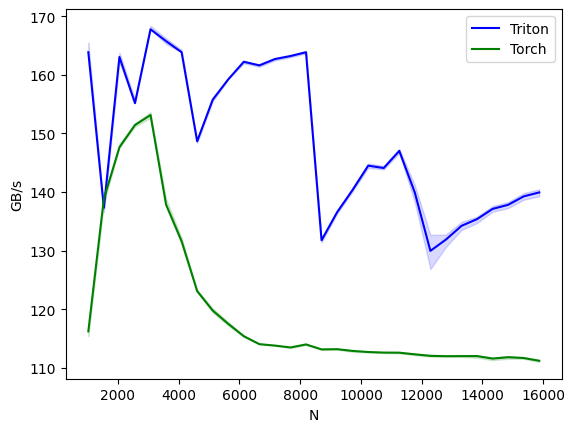

<Figure size 640x480 with 0 Axes>

In [6]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],
        x_vals=[512 * i for i in range(2, 32)],
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("green", "-"), ("orange", "-")],
        ylabel="GB/s",
        plot_name="layer-norm-backward",
        args={"M": 4096, "dtype": torch.float16, "mode": "forward"},
    )
)
def bench_layer_norm(
    M, N, dtype, provider, mode="backward", eps=1e-5, device=torch.device("cuda")
):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1],)
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = 0.1 * torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():

        if provider == "triton":
            return layer_norm(x, w_shape, weight, bias, eps)  # noqa: F811, E704

        if provider == "torch":
            return torch.nn.functional.layer_norm(
                x, w_shape, weight, bias, eps
            )  # noqa: F811, E704

    # forward pass
    if mode == "forward":
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(
            y_fwd, quantiles=quantiles, rep=500
        )
    # backward pass
    if mode == "backward":
        y = y_fwd()
        gbps = (
            lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        )  # noqa: F811, E704
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: y.backward(dy, retain_graph=True),
            quantiles=quantiles,
            grad_to_none=[x],
            rep=500,
        )
    return gbps(ms), gbps(max_ms), gbps(min_ms)


bench_layer_norm.run(show_plots=True, print_data=False, save_path="./benchmark")

### Backward

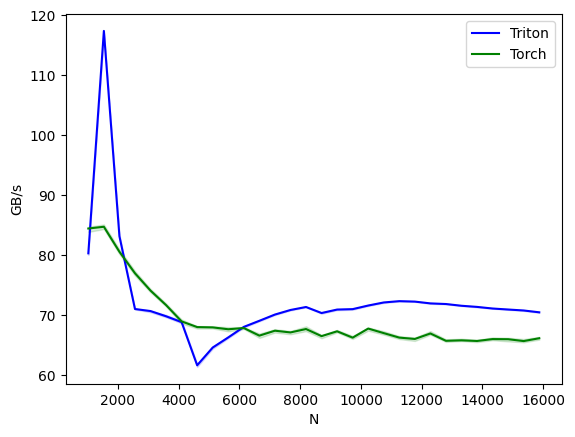

<Figure size 640x480 with 0 Axes>

In [5]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=["N"],
        x_vals=[512 * i for i in range(2, 32)],
        line_arg="provider",
        line_vals=["triton", "torch"],
        line_names=["Triton", "Torch"],
        styles=[("blue", "-"), ("green", "-"), ("orange", "-")],
        ylabel="GB/s",
        plot_name="layer-norm-backward",
        args={"M": 4096, "dtype": torch.float16, "mode": "backward"},
    )
)
def bench_layer_norm(
    M, N, dtype, provider, mode="backward", eps=1e-5, device=torch.device("cuda")
):
    # create data
    x_shape = (M, N)
    w_shape = (x_shape[-1],)
    weight = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    bias = torch.rand(w_shape, dtype=dtype, device=device, requires_grad=True)
    x = -2.3 + 0.5 * torch.randn(x_shape, dtype=dtype, device=device)
    dy = 0.1 * torch.randn_like(x)
    x.requires_grad_(True)
    quantiles = [0.5, 0.2, 0.8]

    def y_fwd():

        if provider == "triton":
            return layer_norm(x, w_shape, weight, bias, eps)  # noqa: F811, E704

        if provider == "torch":
            return torch.nn.functional.layer_norm(
                x, w_shape, weight, bias, eps
            )  # noqa: F811, E704

    # forward pass
    if mode == "forward":
        gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        ms, min_ms, max_ms = triton.testing.do_bench(
            y_fwd, quantiles=quantiles, rep=500
        )
    # backward pass
    if mode == "backward":
        y = y_fwd()
        gbps = (
            lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
        )  # noqa: F811, E704
        ms, min_ms, max_ms = triton.testing.do_bench(
            lambda: y.backward(dy, retain_graph=True),
            quantiles=quantiles,
            grad_to_none=[x],
            rep=500,
        )
    return gbps(ms), gbps(max_ms), gbps(min_ms)


bench_layer_norm.run(show_plots=True, print_data=False, save_path="./benchmark")